In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers


In [11]:
warnings.filterwarnings("ignore")

In [22]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2015-01-01',end='2020-12-31')
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000,1511.0
mean,82.206896,82.968893,81.445765,82.205533,1.551853e+07,0.009887,0.0
std,22.829643,23.042575,22.634188,22.824209,6.771181e+06,0.081388,0.0
min,44.681966,45.383556,41.570070,44.559078,3.324300e+06,0.000000,0.0
25%,56.433764,56.713373,56.017183,56.434137,1.114535e+07,0.000000,0.0
50%,86.894203,88.044224,85.913343,86.872887,1.377760e+07,0.000000,0.0
75%,99.336537,100.329634,98.336740,99.256760,1.772140e+07,0.000000,0.0
max,129.942660,131.580804,129.348252,131.048004,5.619230e+07,0.900000,0.0


In [23]:
# Elimino la colonna 'Stock Splits', poichè è una colonna contenente tutti zeri, è aggiungo la colonna relativa ai rendimenti del titolo
# che serve soltanto per l'analisi esplorativa
JPM = JPM.drop('Stock Splits', axis = 1)
JPM['Rendimenti'] = JPM['Open'].diff()
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Rendimenti
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000,1510.000000
mean,82.206896,82.968893,81.445765,82.205533,1.551853e+07,0.009887,0.045864
std,22.829643,23.042575,22.634188,22.824209,6.771181e+06,0.081388,1.505813
min,44.681966,45.383556,41.570070,44.559078,3.324300e+06,0.000000,-10.086378
25%,56.433764,56.713373,56.017183,56.434137,1.114535e+07,0.000000,-0.568298
50%,86.894203,88.044224,85.913343,86.872887,1.377760e+07,0.000000,0.064532
75%,99.336537,100.329634,98.336740,99.256760,1.772140e+07,0.000000,0.678116
max,129.942660,131.580804,129.348252,131.048004,5.619230e+07,0.900000,10.493408


ANALISI ESPLORATIVA:


Verrà effettuata un'analisi esplorativa sia grafica sull'andamento dei prezzi di apertura e dei rendimenti del titolo, sia volta a studiare la forza della correlazione serialedi ogni titolo ed eventuale presenza di cointegrazione fra i titoli.

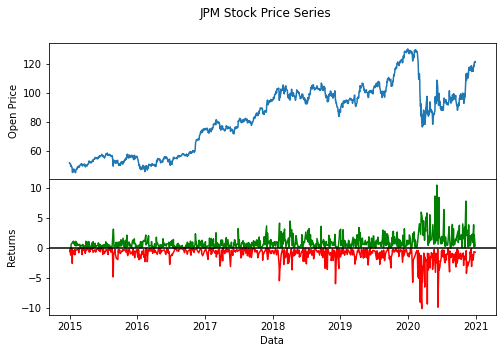

In [5]:
neg = JPM['Rendimenti']>=0
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'][neg==True], color = "green")
axs[1].plot(JPM['Rendimenti'][neg==False], color = "red")
axs[1].axhline(y=0.045864, color = "black", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()

# la serie mostra un forte trend, e una volatilità crescente con un cluster abbastanza corposo nell'ultimo periodo.


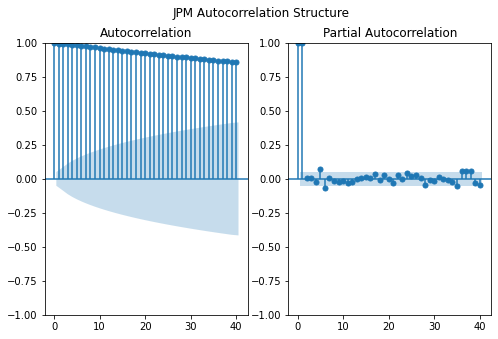

In [6]:
# ACF E PACF della serie; utile anche a capire l'ordine del modello ARIMA
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()

MODELLAZIONE ARIMA



In [26]:
# creazione del train e del test set
filter_row = JPM.index.to_series().between('2015-01-01', '2019-12-31')
test_set = JPM[filter_row == False]
training_set = JPM[filter_row==True]
mc = MinMaxScaler(feature_range=(0,1))
training_set_scaled= mc.fit_transform(training_set[['Open']].values)

In [45]:
modello_AAPL = ARIMA(train, order = (2,1,0)).fit()
modello_AAPL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  252
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -272.079
Date:                Sun, 19 Jun 2022   AIC                            550.158
Time:                        14:45:15   BIC                            560.734
Sample:                             0   HQIC                           554.414
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0418      0.066      0.631      0.528      -0.088       0.172
ar.L2          0.0005      0.065      0.008      0.994      -0.128       0.129
sigma2         0.5117      0.036     14.239      0.000       0.441       0.582
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                37.16
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.37
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 30.792342834223025


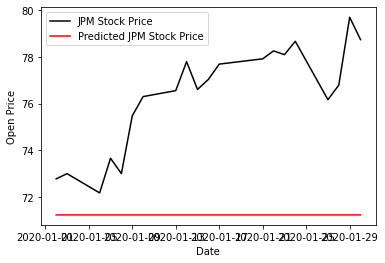

In [46]:
# MSE
yhat_AAPL = modello_AAPL.forecast(steps=20)
MSE_AAPL=mean_squared_error(test, yhat_AAPL)
print("MSE:",MSE_AAPL)
yhat_AAPL.index = test.index
plt.plot(test, color = "black", label = "JPM Stock Price")
plt.plot(yhat_AAPL, color = "red", label = "Predicted JPM Stock Price")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

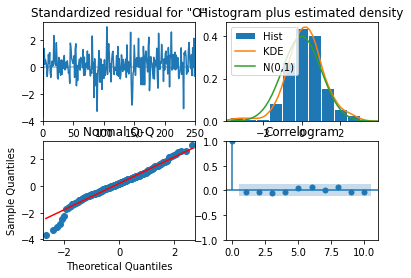

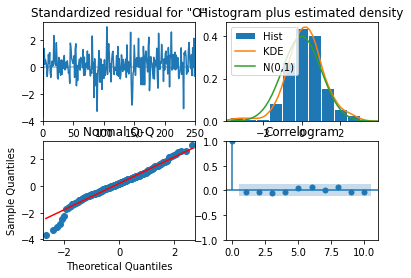

In [47]:
modello_AAPL.plot_diagnostics()

5.19187725493122


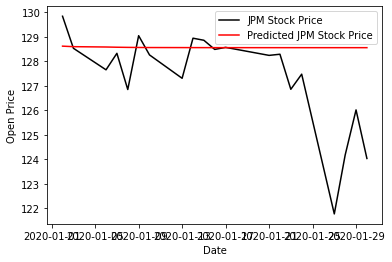

In [49]:
yhat_JPM = modello_JPM.forecast(steps=20)
MSE_JPM=mean_squared_error(test, yhat_JPM)
print(MSE_JPM)
yhat_JPM.index = test.index
plt.plot(test, color = "black", label = "JPM Stock Price")
plt.plot(yhat_JPM, color = "red", label = "Predicted JPM Stock Price")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

CONVOLUTIONAL NEURAL NETWORK

In [37]:
# Costruzione del set di training per la multi-step walk forward validation con finestra temporale di 5 giorni
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set.shape[0]):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(1253, 5, 1)
(1253, 1)


In [ ]:
print(test_set.shape)

In [54]:
 # Costruzione del set di test per la multi step walk forward validation, con finestra temporale di 5 giorni
dataset_total = pd.concat((training_set['Open'], test_set['Open']), axis = 0)
inputs = dataset_total[len(training_set) - len(test_set) - temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(temp, inputs.shape[0]):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(511,)
(506, 5, 1)


In [56]:
model = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 4, 64)             192       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
____________________________________________________

In [57]:
batch_size = 4
epochs = 20
model.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
314/314 [==============================] - 1s 1ms/step - loss: 0.0128 - MSE: 0.0128
Epoch 2/20
314/314 [==============================] - 0s 1ms/step - loss: 3.7584e-04 - MSE: 3.7584e-04
Epoch 3/20
314/314 [==============================] - 0s 1ms/step - loss: 3.7920e-04 - MSE: 3.7920e-04
Epoch 4/20
314/314 [==============================] - 0s 1ms/step - loss: 3.5763e-04 - MSE: 3.5763e-04
Epoch 5/20
314/314 [==============================] - 0s 1ms/step - loss: 3.9871e-04 - MSE: 3.9871e-04
Epoch 6/20
314/314 [==============================] - 0s 1ms/step - loss: 3.4846e-04 - MSE: 3.4846e-04
Epoch 7/20
314/314 [==============================] - 0s 1ms/step - loss: 3.2905e-04 - MSE: 3.2905e-04
Epoch 8/20
314/314 [==============================] - 0s 1ms/step - loss: 3.2467e-04 - MSE: 3.2467e-04
Epoch 9/20
314/314 [==============================] - 0s 1ms/step - loss: 3.6985e-04 - MSE: 3.6985e-04
Epoch 10/20
314/314 [==============================] - 0s 1ms/step - loss: 3.0377

In [58]:
# valutazione previsiva per la prima settimana out-of-sample

score= model.evaluate(X_test)

16/16 [==============================] - 0s 997us/step - loss: 0.0000e+00 - MSE: 0.0000e+00


In [13]:
checkpoint = keras.callbacks.ModelCheckpoint("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Checkpoints.h5",save_best_only=True, save_weights_only=True, monitor="val_MSE" )

In [46]:
def walk_forward_fitting_procedure(X_test, y_test, n_input):
    #X, y = list(), list()
    in_start = 0
    for _ in range(len(train)):
        in_end = in_start + n_input
        out_end = in_end + n_input
        if out_end <= len(test):
           newX_train = X_test[in_end:out_end]
           newy_train = y_test[in_end:out_end]
           model.fit(newX_train, newy_train)
           X_test=X_test.drop(X_test.index[0:5])
           y_test=y_test.drop(y_test.index[0:5])
           score = model.evaluate(X_test, y_test)
    return score 

In [47]:
score = walk_forward_fitting_procedure(X_test=X_test, y_test=y_test,n_input=5)

1/1 [==============================] - 0s 41ms/step - loss: 21.0359 - MSE: 21.0359


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.